In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

In [2]:
raw_tweet=pd.read_csv('/Users/himanish/Desktop/Pfizer/vaccination_tweets.csv')
raw_tweet.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [3]:
raw_tweet.shape

(8082, 16)

In [4]:
raw_tweet.isnull().sum()

id                     0
user_name              0
user_location       1630
user_description     506
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            1949
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

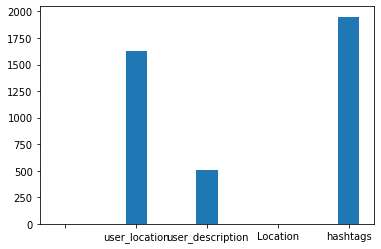

In [5]:
bars=("","","user_location","user_description","","Location","","","","","","hashtags","","","","")
plt.bar(bars,raw_tweet.isnull().sum(),width=0.3)
plt.show()

In [6]:
#cleaning the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [7]:
raw_tweet['text'] = clean_tweets(raw_tweet['text'])

In [23]:
raw_tweet['text'].head()

0    Same folks said daikon paste could treat a cyt...
1    While the world has been on the wrong side of ...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts are immutable, Senator, even when you're...
4    Explain to me again why we need a vaccine   #w...
Name: text, dtype: object

In [9]:
raw_tweet.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine #w...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [10]:
analyzer=SentimentIntensityAnalyzer()
def analysis(text):
  polarity=analyzer.polarity_scores(text)

  if polarity['compound']>=0.05:
    return 0
  elif polarity['compound']<=-0.05:
    return 1
  else:
    return 2

In [11]:
raw_tweet['sentiment']=raw_tweet['text'].apply(analysis)

In [12]:
raw_tweet.head(30)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,0
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,1
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,0
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,2
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine #w...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,2
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fe...",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance fo...,NaN,Twitter for iPhone,0,0,False,0
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False,0
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 b...,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False,0
8,1337850023531347969,Erin Despas,NaN,Designing&selling on Teespring. Like 90s Disne...,2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVacci...,"['CovidVaccine', 'covid19', 'PfizerBioNTech', ...",Twitter Web App,2,1,False,2
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False,2


In [13]:
raw_tweet['sentiment'].value_counts()

0    3474
2    3207
1    1401
Name: sentiment, dtype: int64

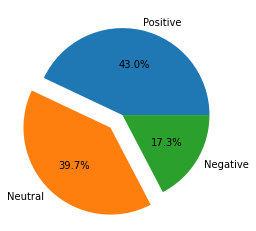

In [24]:
pievalue=raw_tweet['sentiment'].value_counts()
mylabels=['Positive','Neutral',"Negative"]
explode=[0.0,0.2,0.0]
plt.pie(pievalue, labels = mylabels, explode=explode,autopct='%1.1f%%')
plt.show()

In [25]:
vectorizer=TfidfVectorizer(min_df=1,stop_words="english",lowercase=True)

X=raw_tweet['text']
Y=raw_tweet['sentiment']


X_train, X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2)

X_train_feature=vectorizer.fit_transform(X_train)
X_test_feature=vectorizer.transform(X_test)

logistic_model=LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_feature,Y_train)

svm_model=SVC(kernel = 'rbf')
svm_model.fit(X_train_feature,Y_train)


xgb_model=XGBClassifier()
xgb_model.fit(X_train_feature,Y_train)

randomforest_model=RandomForestClassifier()
randomforest_model.fit(X_train_feature,Y_train)

RandomForestClassifier()

In [17]:
prediction_on_training=logistic_model.predict(X_train_feature)
accuracy_on_training=accuracy_score(Y_train,prediction_on_training)
print("Accuracy on training data of logistic regression model",accuracy_on_training*100,"%")

prediction_on_test=logistic_model.predict(X_test_feature)
accuracy_on_test=accuracy_score(Y_test,prediction_on_test)
print("Accuracy on test data of logistic regression model",accuracy_on_test*100,"%")


prediction_on_training=svm_model.predict(X_train_feature)
accuracy_on_training=accuracy_score(Y_train,prediction_on_training)
print("Accuracy on training data of support vector machine model",accuracy_on_training*100,"%")

prediction_on_test=svm_model.predict(X_test_feature)
accuracy_on_test=accuracy_score(Y_test,prediction_on_test)
print("Accuracy on test data of support vector machine model",accuracy_on_test*100,"%")

prediction_on_training=xgb_model.predict(X_train_feature)
accuracy_on_training=accuracy_score(Y_train,prediction_on_training)
print("Accuracy on training data of XGBoost model",accuracy_on_training*100,"%")

prediction_on_test=svm_model.predict(X_test_feature)
accuracy_on_test=accuracy_score(Y_test,prediction_on_test)
print("Accuracy on test data of XGBoost model",accuracy_on_test*100,"%")


prediction_on_training=randomforest_model.predict(X_train_feature)
accuracy_on_training=accuracy_score(Y_train,prediction_on_training)
print("Accuracy on training data of random forest model",accuracy_on_training*100,"%")

prediction_on_test=randomforest_model.predict(X_test_feature)
accuracy_on_test=accuracy_score(Y_test,prediction_on_test)
print("Accuracy on test data of random forest model",accuracy_on_test*100,"%")

Accuracy on training data of logistic regression model 90.5491105955143 %
Accuracy on test data of logistic regression model 75.69573283858998 %
Accuracy on training data of support vector machine model 98.14385150812065 %
Accuracy on test data of support vector machine model 75.01546072974644 %
Accuracy on training data of XGBoost model 84.11446249033257 %
Accuracy on test data of XGBoost model 75.01546072974644 %
Accuracy on training data of random forest model 99.96906419180202 %
Accuracy on test data of random forest model 75.07730364873223 %


# Prediction System

In [18]:
input_tweet=["Pfizer is not a great vaccine"]
predictions=vectorizer.transform(input_tweet)
result=randomforest_model.predict(predictions)
if result[0]==0:
  print("Postive")
elif result[0]==1:
  print("Negative")
elif result[0]==2:
  print("Neutral")

Postive


In [19]:

input_tweet=["Pfizer is not a great vaccine"]
predictions=vectorizer.transform(input_tweet)
result=xgb_model.predict(predictions)
if result[0]==0:
  print("Postive")
elif result[0]==1:
  print("Negative")
elif result[0]==2:
  print("Neutral")

Postive


In [20]:
input_tweet=["Pfizer is not a great vaccine"]
predictions=vectorizer.transform(input_tweet)
result=svm_model.predict(predictions)
if result[0]==0:
  print("Postive")
elif result[0]==1:
  print("Negative")
elif result[0]==2:
  print("Neutral")

Postive


In [21]:
input_tweet=["Pfizer is not a great vaccine"]
predictions=vectorizer.transform(input_tweet)
result=logistic_model.predict(predictions)
if result[0]==0:
  print("Postive")
elif result[0]==1:
  print("Negative")
elif result[0]==2:
  print("Neutral")

Postive
